In [1]:
!pip install --upgrade tensorflow

In [2]:
!pip install --upgrade numpy

In [3]:
import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import roc_curve, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [4]:
train_path="/kaggle/input/deepfake-and-real-images/Dataset/Train"
test_path="/kaggle/input/deepfake-and-real-images/Dataset/Test"
val_path="/kaggle/input/deepfake-and-real-images/Dataset/Validation"

In [5]:
train_datagen = ImageDataGenerator( 
                                   rescale=1./255,
                                   #rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                  ) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(  rescale=1./255.0)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299,299),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299,299),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (299,299),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [6]:
# data input shape
input_shape = (299, 299, 3) 

# Xception model 
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True
    
# custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# final model
combined_model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,927,593 (79.83 MB)

 Trainable params: 7,392,489 (28.20 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

In [8]:
learning_rate = 0.000001  

# Adam optimizer instance with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)


In [9]:
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
history = combined_model.fit(
    training_set,
    epochs=20,
    validation_data=val_set
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1846s 416ms/step - accuracy: 0.5370 - loss: 0.6766 - val_accuracy: 0.7759 - val_loss: 0.5593
Epoch 2/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 860s 196ms/step - accuracy: 0.7919 - loss: 0.5098 - val_accuracy: 0.8275 - val_loss: 0.4097
Epoch 3/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 869s 198ms/step - accuracy: 0.8520 - loss: 0.3643 - val_accuracy: 0.8505 - val_loss: 0.3449
Epoch 4/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 867s 198ms/step - accuracy: 0.8832 - loss: 0.2902 - val_accuracy: 0.8666 - val_loss: 0.3096
Epoch 5/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 870s 199ms/step - accuracy: 0.8996 - loss: 0.2499 - val_accuracy: 0.8756 - val_loss: 0.2881
Epoch 6/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 880s 201ms/step - accuracy: 0.9113 - loss: 0.2228 - val_accuracy: 0.8835 - val_loss: 0.2707
Epoch 7/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 872s 199ms/step - accuracy: 0.9182 - loss: 0.2035 - val_accuracy: 0.8905 - val_loss: 0.2563
Epoch 8/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 871s 199ms/step - accuracy: 0.

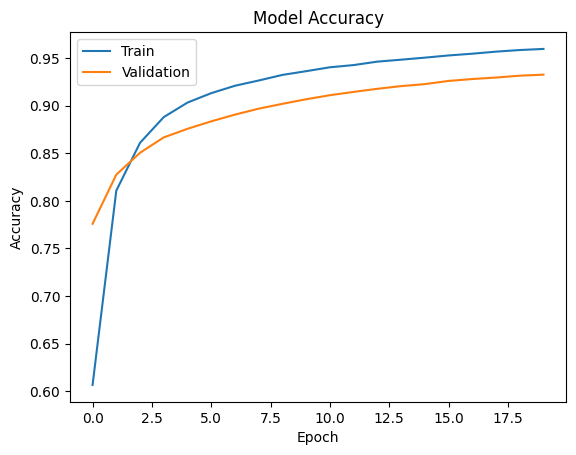

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

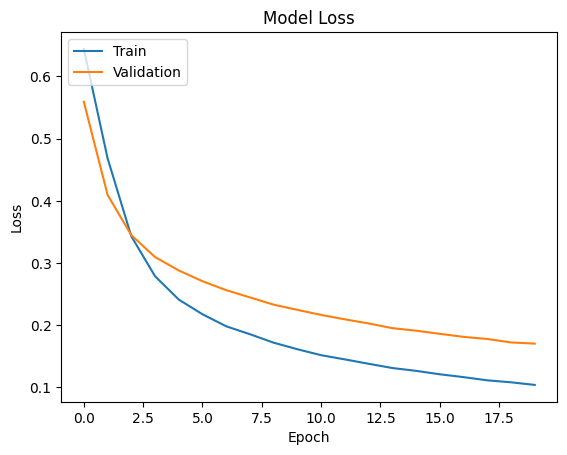

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# the test set ==> predict classes
test_pred = combined_model.predict(test_set)
test_pred_classes = np.round(test_pred)

# finding the true classes of test set
test_true_classes = test_set.classes

341/341 ━━━━━━━━━━━━━━━━━━━━ 131s 377ms/step


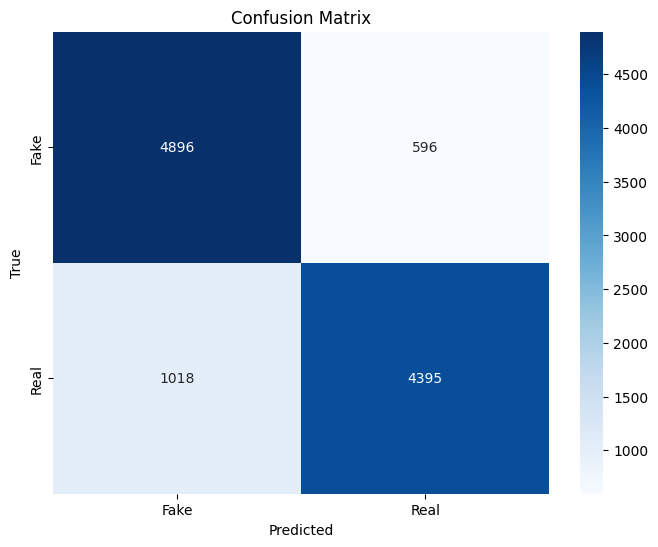

In [14]:
# confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
evaluation = combined_model.evaluate(test_set)

341/341 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.8866 - loss: 0.2687


In [16]:
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

Test Accuracy: 85.20%


In [17]:
#Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0     0.8279    0.8915    0.8585      5492
     Class 1     0.8806    0.8119    0.8449      5413

    accuracy                         0.8520     10905
   macro avg     0.8542    0.8517    0.8517     10905
weighted avg     0.8540    0.8520    0.8517     10905



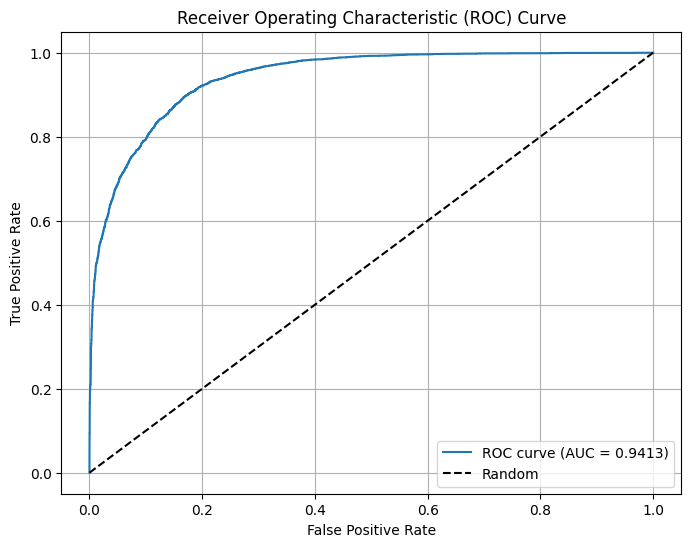

In [18]:
# ROC curve
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)

# AUC
auc = roc_auc_score(test_true_classes, test_pred)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

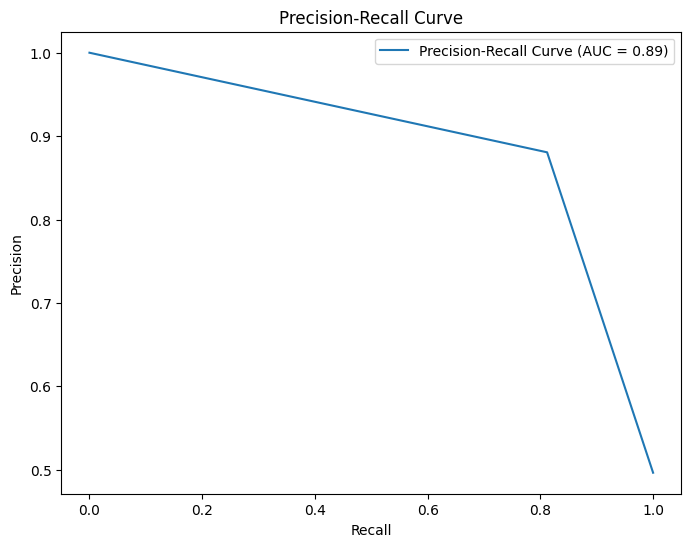

In [19]:
from sklearn.metrics import precision_recall_curve, auc

# precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)

# Calculating the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [20]:
# Computing confusion matrix
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()

# sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

Sensitivity (True Positive Rate): 0.8119
Specificity (True Negative Rate): 0.8915


In [21]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# F1 score for the test classes
f1 = f1_score(test_true_classes, test_pred_classes)

# accuracy and error rate
accuracy = accuracy_score(test_true_classes, test_pred_classes)
error_rate = 1 - accuracy

# G-mean
g_mean = (sensitivity * specificity) ** 0.5

# F-measure
f_measure = 2 * ((sensitivity * specificity) / (sensitivity + specificity))

print(f'F1 Score: {f1:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'G-mean: {g_mean:.4f}')
print(f'F-measure: {f_measure:.4f}')

F1 Score: 0.8449
Error Rate: 0.1480
G-mean: 0.8508
F-measure: 0.8498


In [22]:
# Check 01

import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = combined_model  # Assuming combined_model is the trained model from the notebook

# Define the path to the test image (update this with the actual path to your test image)
test_image_path = os.path.join(test_path, '/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake/fake_1000.jpg')  # Update with the correct image path

# Load the image with target size (299, 299) as used in the model
img = image.load_img(test_image_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape of model input
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same as the normalization used during training)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the result
predicted_class = 'Fake' if prediction[0][0] > 0.5 else 'Real'
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted class is: Fake


In [23]:
# check 3
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = combined_model  # Assuming combined_model is the trained model from the notebook

# Define the path to the test image (update this with the actual path to your test image)
test_image_path = os.path.join(test_path, '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_1000.jpg')  # Update with the correct image path

# Load the image with target size (299, 299) as used in the model
img = image.load_img(test_image_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape of model input
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same as the normalization used during training)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the result
predicted_class = 'Fake' if prediction[0][0] > 0.5 else 'Real'
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The predicted class is: Fake


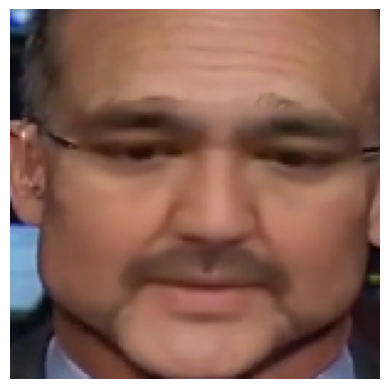

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the image
image_path = '/kaggle/input/faceforensics/cropped_images/002_006/0075.png'  # Update this path if needed

# Open the image
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


In [25]:
# check 2


import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = combined_model  # Assuming combined_model is the trained model from the notebook

# Define the path to the test image (update this with the actual path to your test image)
test_image_path = os.path.join(test_path, '/kaggle/input/faceforensics/cropped_images/002_006/0075.png')  # Update with the correct image path

# Load the image with target size (299, 299) as used in the model
img = image.load_img(test_image_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape of model input
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same as the normalization used during training)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the result
predicted_class = 'Fake' if prediction[0][0] > 0.5 else 'Real'
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class is: Real


In [26]:
# check 4
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = combined_model  # Assuming combined_model is the trained model from the notebook

# Define the path to the test image (update this with the actual path to your test image)
test_image_path = os.path.join(test_path, '/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_1.jpg')  # Update with the correct image path

# Load the image with target size (299, 299) as used in the model
img = image.load_img(test_image_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape of model input
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same as the normalization used during training)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the result
predicted_class = 'Fake' if prediction[0][0] > 0.5 else 'Real'
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted class is: Real


In [27]:
# check 4
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = combined_model  # Assuming combined_model is the trained model from the notebook

# Define the path to the test image (update this with the actual path to your test image)
test_image_path = os.path.join(test_path, '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_1000.jpg')  # Update with the correct image path

# Load the image with target size (299, 299) as used in the model
img = image.load_img(test_image_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape of model input
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same as the normalization used during training)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)

# Interpret the result
predicted_class = 'Fake' if prediction[0][0] > 0.5 else 'Real'
print(f'The predicted class is: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The predicted class is: Fake
